<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/Vgg16model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive

/content/drive


In [ ]:
%cd MyDrive

/content/drive/MyDrive


In [ ]:
%cd medical-image-analysis

/content/drive/MyDrive/medical-image-analysis


In [ ]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

Cloning into 'medical-image-analysis'...
remote: Enumerating objects: 3802, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 3802 (delta 19), reused 0 (delta 0), pack-reused 3763
Receiving objects: 100% (3802/3802), 337.16 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (3889/3889), done.


In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import itertools
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing import image
from glob import glob

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [ ]:
eczema_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Eczema Photos", 224))
melanoma_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


100%|██████████| 352/352 [00:02<00:00, 142.63it/s]


In [ ]:
#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melanoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

In [ ]:
X_train = np.concatenate((eczema_train, melanoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)
X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)
print(Y_test.shape)
print(X_test.shape)

(777,)
(777, 224, 224, 3)


In [ ]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.3, 
    random_state=5
)

In [ ]:
X_train.shape, Y_train.shape

((2172, 224, 224, 3), (2172, 3))

In [ ]:
X_val.shape, Y_val.shape

((931, 224, 224, 3), (931, 3))

In [ ]:
X_test.shape, Y_test.shape

((777, 224, 224, 3), (777, 3))

In [ ]:
#load in pretrained model
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#adding output layer
top_model = vgg.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(3, activation='softmax')(top_model)

In [ ]:
#create a model object
model4 = Model(inputs=vgg.input, outputs=output_layer)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
#Feature extraction
train_datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.3, height_shift_range=0.3,
                                   shear_range=0.3, zoom_range=0.3, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.3, height_shift_range=0.3,
                                   shear_range=0.3, zoom_range=0.3, fill_mode='nearest')
val_datagen.fit(X_val)


In [ ]:
batch_size = 64
epochs = 10
history4 = model4.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))


Epoch 1/10
33/33 [==============================] - 99s 1s/step - loss: 11.1735 - accuracy: 0.4569 - val_loss: 2.0677 - val_accuracy: 0.5134
Epoch 2/10
33/33 [==============================] - 31s 937ms/step - loss: 1.9342 - accuracy: 0.5197 - val_loss: 1.4034 - val_accuracy: 0.5491
Epoch 3/10
33/33 [==============================] - 31s 935ms/step - loss: 1.2627 - accuracy: 0.5435 - val_loss: 1.0148 - val_accuracy: 0.5692
Epoch 4/10
33/33 [==============================] - 31s 934ms/step - loss: 1.0019 - accuracy: 0.5679 - val_loss: 0.8769 - val_accuracy: 0.5871
Epoch 5/10
33/33 [==============================] - 31s 935ms/step - loss: 0.8753 - accuracy: 0.5993 - val_loss: 0.9201 - val_accuracy: 0.5536
Epoch 6/10
33/33 [==============================] - 31s 932ms/step - loss: 0.8435 - accuracy: 0.6109 - val_loss: 0.8018 - val_accuracy: 0.5781
Epoch 7/10
33/33 [==============================] - 31s 937ms/step - loss: 0.7926 - accuracy: 0.6239 - val_loss: 0.8780 - val_accuracy: 0.6071
E

In [ ]:
#Fine-Tuning 
for layer in model4.layers[13:]:
    layer.trainable = True

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [ ]:
batch_size = 64
epochs = 30
history = model4.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/30
33/33 [==============================] - 36s 988ms/step - loss: 0.9014 - acc: 0.5873 - val_loss: 0.8130 - val_acc: 0.6116
Epoch 2/30
33/33 [==============================] - 32s 956ms/step - loss: 0.8354 - acc: 0.5818 - val_loss: 0.8287 - val_acc: 0.5804
Epoch 3/30
33/33 [==============================] - 32s 960ms/step - loss: 0.7708 - acc: 0.6065 - val_loss: 0.8775 - val_acc: 0.5625
Epoch 4/30
33/33 [==============================] - 32s 958ms/step - loss: 0.7660 - acc: 0.6355 - val_loss: 0.7597 - val_acc: 0.6429
Epoch 5/30
33/33 [==============================] - 32s 958ms/step - loss: 0.7431 - acc: 0.6577 - val_loss: 0.7547 - val_acc: 0.6272
Epoch 6/30
33/33 [==============================] - 32s 963ms/step - loss: 0.7312 - acc: 0.6520 - val_loss: 0.7508 - val_acc: 0.6763
Epoch 7/30
33/33 [==============================] - 32s 963ms/step - loss: 0.6751 - acc: 0.6961 - val_loss: 0.6894 - val_acc: 0.7054
Epoch 8/30
33/33 [==============================] - 32s 971ms/step - 

In [ ]:
loss_val, acc_val = model4.evaluate(X_val, Y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

30/30 [==============================] - 6s 176ms/step - loss: 0.7960 - acc: 0.7830
Validation: accuracy = 0.783029  ;  loss_v = 0.795988


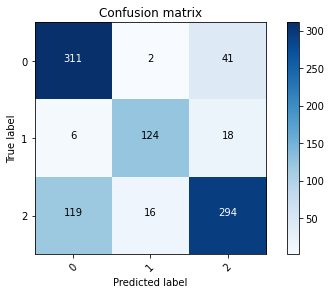

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model4.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

TESTING4


In [ ]:
loss_test, acc_test = model4.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

25/25 [==============================] - 6s 231ms/step - loss: 0.7847 - acc: 0.7786
Test: accuracy = 0.778636  ;  loss = 0.784712


Text(0.5, 1.0, 'Training and validation loss')

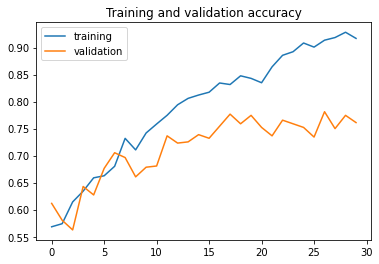

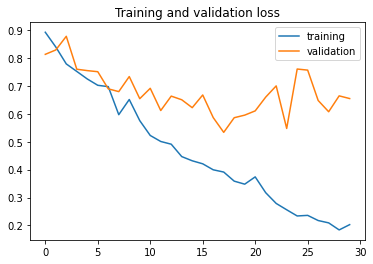

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
model4.save("VGG16model4.h5")